# Data Wrangling on SVHN Dataset

## Download and extract SVHN dataset

In [1]:
# Modules we might be using
import numpy as np
import os
import sys
import tarfile
from six.moves.urllib.request import urlretrieve
import h5py # for parsing images metadata
from IPython.display import Image as img, display
from PIL import Image
from scipy.stats import stats # for statistical description of variables

# dumping pickle file
from six.moves import cPickle as pickle 

# Config the matplotlib backend as plotting inline in IPython
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
url = 'http://ufldl.stanford.edu/housenumbers/'

def maybe_download(filename, force=False):
    """ Download a file if not present """
    if (force or not os.path.exists(filename)):
        filename, _ = urlretrieve(url + filename, filename)
        print("%s downloaded" % filename)
    else:
        print("%s already present" % filename)
    return filename

# download training set
train_filename = maybe_download('train.tar.gz')
# download testing set
test_filename = maybe_download('test.tar.gz')

train.tar.gz already present
test.tar.gz already present


In [3]:
def maybe_extract(filename, force=False):
    """ Extract a tar file """
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall()
        tar.close()
        print('Extracted')
    return root
# extract training data
train_folder = maybe_extract(train_filename)
# extract testing data
test_folder = maybe_extract(test_filename)

train already present - Skipping extraction of train.tar.gz.
test already present - Skipping extraction of test.tar.gz.


## Preprocess SVHN sataset

In [4]:
class DigitImages:
    metadata_file_name = "digitStruct.mat"
    def __init__(self, data_folder):
        # read training images metadata/lablels
        self.data_folder = data_folder
        metadata_file = os.path.join(data_folder, self.metadata_file_name)
        self.de = h5py.File(metadata_file, 'r')
        self.Iname = self.de['digitStruct']['name']
        self.Ibbox = self.de['digitStruct']['bbox']
    
    # different functions' definition to explore/process images
    def getImageFileName(self, imageNum):
        ''' get file name of image '''
        return ''.join([chr(c[0]) for c in self.de[self.Iname[imageNum][0]].value])
    
    def getImageFullFileName(self, imageNum):
        return os.path.join(self.data_folder, self.getImageFileName(imageNum))

    def displayImage(self, imageNum):
        ''' display image '''
        fileName = self.getImageFullFileName(imageNum)
        display(img(fileName))

    def getNumberOfDigits(self, imageNum):
        ''' get number of digits in image '''
        return self.de[self.Ibbox[imageNum][0]]['label'].shape[0]

    def getImageAttr(self, imageNum, digNum, attr):
        ''' get attr attribute details of digNum digit '''
        hf = self.de[self.Ibbox[imageNum][0]][attr][digNum][0]
        if type(hf) == np.float64:
            return hf
        else:
            return self.de[hf][0][0]
    
    def getPreProcessImageDimWithBoundingBox(self, imageId):
        ''' get boundaries of box which bounds the digits in image '''
        tops = []
        bottoms = []
        lefts = []
        rights = []

        num_dig = self.getNumberOfDigits(imageId)
        for dig in xrange(num_dig):
            if dig >= 5:
                continue
            height = self.getImageAttr(imageId, dig, 'height')
            width = self.getImageAttr(imageId, dig, 'width')
            top = self.getImageAttr(imageId, dig, 'top')
            left = self.getImageAttr(imageId, dig, 'left')

            tops.append(top)
            bottoms.append(height+top)
            lefts.append(left)
            rights.append(width+left)
        
        left = np.int(np.floor(np.min(lefts)))
        top = np.int(np.floor(np.min(tops)))
        right = np.int(np.floor(np.max(rights)))
        bottom = np.int(np.floor(np.max(bottoms)))
        return (left, top, right, bottom)
    
    def getCroppedImage(self, imageId):
        dim = self.getPreProcessImageDimWithBoundingBox(imageId)
        fileName = self.getImageFullFileName(imageId)
        im = Image.open(fileName)
        im = im.crop(dim).resize([32, 32], Image.ANTIALIAS)
        return im

    def getImageLabels(self, imageId):
        ''' get labels (digits) corresponding to image '''
        labels = np.ones(5, dtype = int)*10
        num_dig = self.getNumberOfDigits(imageId)
        # labels[0] = num_dig
        for dig in xrange(num_dig):
            if dig < 5:
                lab = self.getImageAttr(imageId, dig, 'label')
                if lab == 10:
                    lab = 0
                labels[dig] = lab
            else:
                print('> 5 digits found in', imageId)
        return labels
    
    def debug(self, imageId):
        ''' debugs image '''
        print("FILE NAME: %s" % self.getImageFileName(imageId))
        print("ORIGINAL IMAGE:")
        self.displayImage(imageId)
        numDigit = self.getNumberOfDigits(imageId)
        print("NUMBER OF DIGITS: %d" % numDigit)
        for dig in range(numDigit):
            print("FOR DIGIT %d" % (dig+1))
            print("  LEFT: %d" % self.getImageAttr(imageId, dig, 'left'))
            print("  WIDTH: %d" % self.getImageAttr(imageId, dig, 'width'))
            print("  TOP: %d" % self.getImageAttr(imageId, dig, 'top'))
            print("  HEIGHT: %d" % self.getImageAttr(imageId, dig, 'height'))
            print("  LABEL: %d" % self.getImageAttr(imageId, dig, 'label'))
        print("PROCESSED IMAGE:")
        display(self.getCroppedImage(imageId))
        lb = self.getImageLabels(imageId)
        print("LABELS:")
        display(lb)
        
    def getNumberOfImages(self):
        return self.Iname.shape[0]
        
    def explore(self):
        ''' explore statistical properties of data set '''
        numImages = self.getNumberOfImages()
        print("TOTAL NUMBER OF IMAGES: %d" % numImages)
        numDigImages = np.zeros(6, dtype=int) # hash of count of images with particular digits
        widths = np.zeros(numImages, dtype=int) # widths of images
        heights = np.zeros(numImages, dtype=int)# heights of images
        areas = np.zeros(numImages, dtype=int) # areas of images
        for imageId in range(numImages):
            numDigit = self.getNumberOfDigits(imageId)
            if numDigit <= 5:
                numDigImages[numDigit] = numDigImages[numDigit] + 1;
            fileName = self.getImageFullFileName(imageId)
            im = Image.open(fileName)
            width, height = im.size
            widths[imageId] = (width)
            heights[imageId] = (height)
            areas[imageId] = (width*height)
            
        print("COUNT FREQUENCY OF NUMBER OF DIGITS IN IMAGE:")
        display(numDigImages)
        plt.figure()
        plt.bar((0,1,2,3,4,5), numDigImages)
        plt.title("NUMBER OF IMAGES WITH DIGITS COUNT")
        plt.xlabel("DIGIT COUNT")
        plt.ylabel("NUMBER OF IMAGES")

        print("STATISTICAL PROPERTIES OF WIDTHS OF IMAGES:")
        display(stats.describe(widths))
        plt.figure()
        plt.hist(widths,  range=[0,400])
        plt.title("DISTIRUBTION OF IMAGE WIDTHS")
        plt.xlabel("WIDTH")
        plt.ylabel("FREQUENCY")
            
        print("STATISTICAL PROPERTIES OF HEIGHTS OF IMAGES:")
        display(stats.describe(heights))
        plt.figure()
        plt.hist(heights, range=[0,400])
        plt.title("DISTIRUBTION OF IMAGE HEIGHTS")
        plt.xlabel("HEIGHT")
        plt.ylabel("FREQUENCY")

        print("STATISTICAL PROPERTIES OF AREAS OF IMAGES:")
        display(stats.describe(areas))
        plt.figure()
        plt.hist(areas, range=[0,60000])
        plt.title("DISTIRUBTION OF IMAGE AREAS")
        plt.xlabel("AREAS")
        plt.ylabel("FREQUENCY")
        
        print("MINIMUM WIDTH IMAGE")
        self.debug(np.argmin(widths))
        print("MAXIMUM WIDTH IMAGE")
        self.debug(np.argmax(widths))
        
        print("MINIMUM HEIGHT IMAGE")
        self.debug(np.argmin(heights))
        print("MAXIMUM HEIGHT IMAGE")
        self.debug(np.argmax(heights))
        
        print("MINIMUM AREA IMAGE")
        self.debug(np.argmin(areas))
        print("MAXIMUM AREA IMAGE")
        self.debug(np.argmax(areas))
        
        return (numDigImages, widths, heights, areas)
    
    def getPreProcessImageArray(self, imageId):
        ''' preprocess the image to fed into model directly '''
        im = self.getCroppedImage(imageId)
        im = np.dot(np.array(im, dtype='float32'), [[0.2989],[0.5879],[0.1140]])
        mean = np.mean(im)
        std = np.std(im)
        if std < 1e-4:
            std = 1
        im = (im - mean)/ std
        return im

    def getDataLabels(self):
        ''' merged function to get both data and labels '''
        numImages = self.getNumberOfImages()
        data = np.ndarray([numImages, 32, 32, 1], dtype='float32')
        labels = np.ones([numImages, 5], dtype = int)*10
        for numImage in xrange(numImages):
            data[numImage,:,:,:] = self.getPreProcessImageArray(numImage)
            labels[numImage,:] = self.getImageLabels(numImage)
        return (data, labels)

('> 5 digits found in', 29929)
TOTAL NUMBER OF IMAGES: 33402
COUNT FREQUENCY OF NUMBER OF DIGITS IN IMAGE:


array([    0,  5137, 18130,  8691,  1434,     9])

STATISTICAL PROPERTIES OF WIDTHS OF IMAGES:


DescribeResult(nobs=33402L, minmax=(25, 876), mean=128.28498293515358, variance=6487.6932501254532, skewness=1.799538067794436, kurtosis=4.397096702140904)

STATISTICAL PROPERTIES OF HEIGHTS OF IMAGES:


DescribeResult(nobs=33402L, minmax=(12, 501), mean=57.213011196934318, variance=1308.9704327814677, skewness=2.0516047810241407, kurtosis=7.477046282784611)

STATISTICAL PROPERTIES OF AREAS OF IMAGES:


DescribeResult(nobs=33402L, minmax=(300, 438876), mean=10103.642745943356, variance=232094472.90643653, skewness=5.591386285920706, kurtosis=73.62478268014097)

MINIMUM WIDTH IMAGE
FILE NAME: 9748.png
ORIGINAL IMAGE:


NUMBER OF DIGITS: 1
FOR DIGIT 1
  LEFT: 8
  WIDTH: 8
  TOP: 1
  HEIGHT: 11
  LABEL: 6
PROCESSED IMAGE:


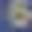

LABELS:


array([ 6, 10, 10, 10, 10])

MAXIMUM WIDTH IMAGE
FILE NAME: 411.png
ORIGINAL IMAGE:


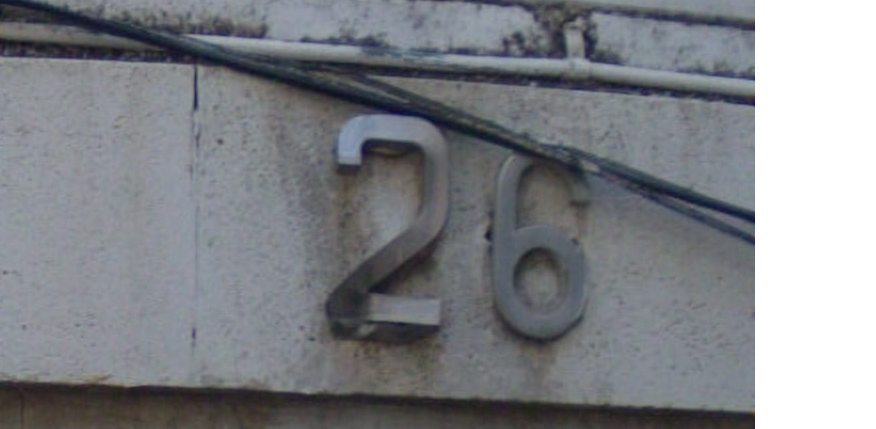

NUMBER OF DIGITS: 2
FOR DIGIT 1
  LEFT: 286
  WIDTH: 176
  TOP: 64
  HEIGHT: 293
  LABEL: 2
FOR DIGIT 2
  LEFT: 489
  WIDTH: 155
  TOP: 69
  HEIGHT: 293
  LABEL: 6
PROCESSED IMAGE:


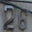

LABELS:


array([ 2,  6, 10, 10, 10])

MINIMUM HEIGHT IMAGE
FILE NAME: 1814.png
ORIGINAL IMAGE:


NUMBER OF DIGITS: 2
FOR DIGIT 1
  LEFT: 9
  WIDTH: 8
  TOP: 1
  HEIGHT: 11
  LABEL: 1
FOR DIGIT 2
  LEFT: 19
  WIDTH: 9
  TOP: 1
  HEIGHT: 11
  LABEL: 3
PROCESSED IMAGE:


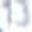

LABELS:


array([ 1,  3, 10, 10, 10])

MAXIMUM HEIGHT IMAGE
FILE NAME: 15856.png
ORIGINAL IMAGE:


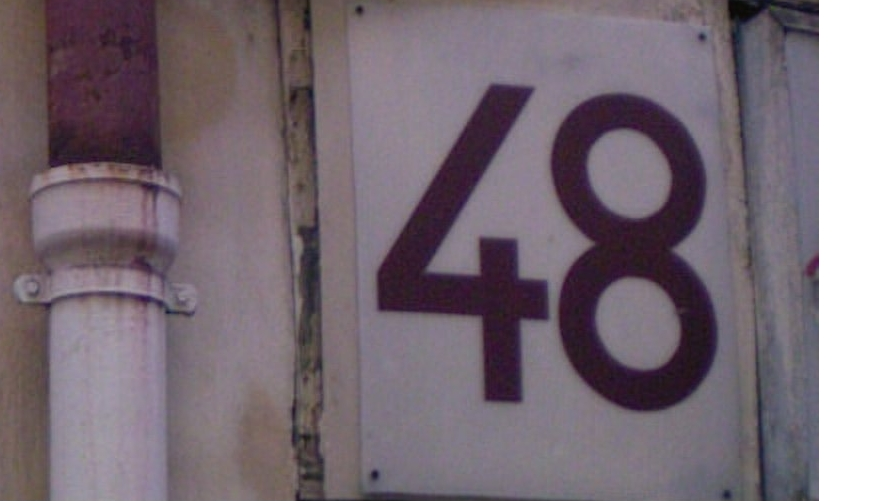

NUMBER OF DIGITS: 2
FOR DIGIT 1
  LEFT: 381
  WIDTH: 176
  TOP: 40
  HEIGHT: 360
  LABEL: 4
FOR DIGIT 2
  LEFT: 566
  WIDTH: 172
  TOP: 49
  HEIGHT: 360
  LABEL: 8
PROCESSED IMAGE:


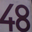

LABELS:


array([ 4,  8, 10, 10, 10])

MINIMUM AREA IMAGE
FILE NAME: 9748.png
ORIGINAL IMAGE:


NUMBER OF DIGITS: 1
FOR DIGIT 1
  LEFT: 8
  WIDTH: 8
  TOP: 1
  HEIGHT: 11
  LABEL: 6
PROCESSED IMAGE:


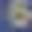

LABELS:


array([ 6, 10, 10, 10, 10])

MAXIMUM AREA IMAGE
FILE NAME: 15856.png
ORIGINAL IMAGE:


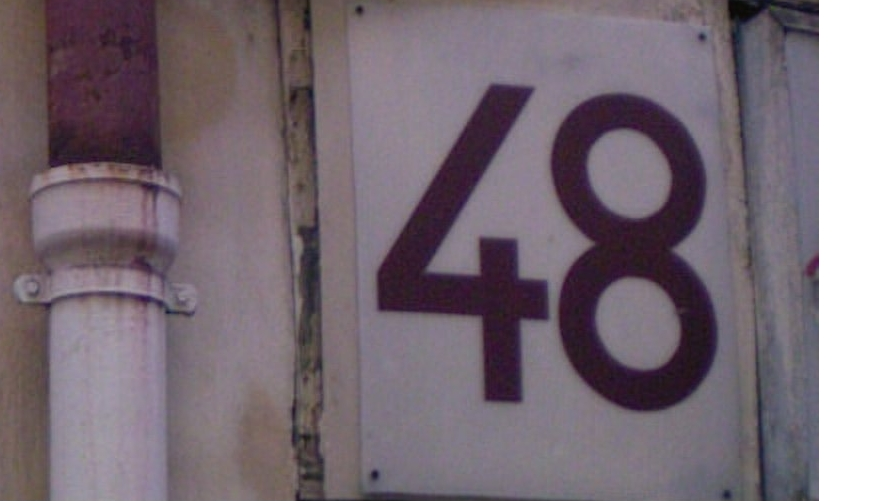

NUMBER OF DIGITS: 2
FOR DIGIT 1
  LEFT: 381
  WIDTH: 176
  TOP: 40
  HEIGHT: 360
  LABEL: 4
FOR DIGIT 2
  LEFT: 566
  WIDTH: 172
  TOP: 49
  HEIGHT: 360
  LABEL: 8
PROCESSED IMAGE:


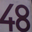

LABELS:


array([ 4,  8, 10, 10, 10])

array([ 2,  3, 10, 10, 10])

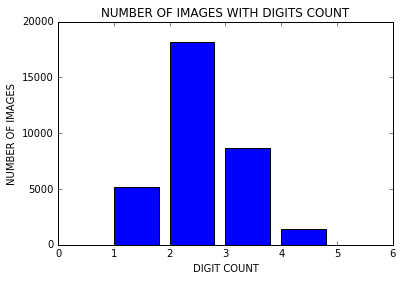

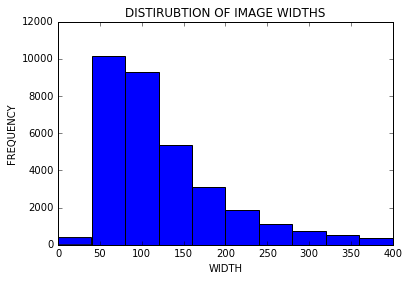

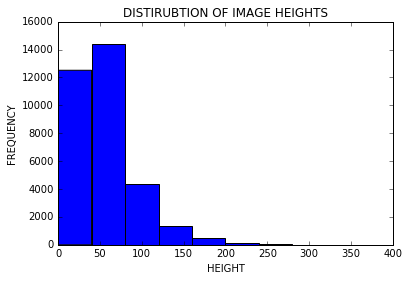

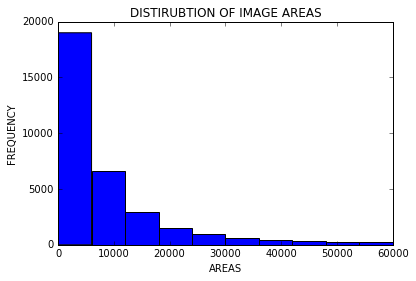

In [5]:
# training dataset
trainDigitObject = DigitImages(train_folder)
(train_data, train_labels) = trainDigitObject.getDataLabels() 
trainDigitObject.explore()
display(train_labels[10])

TOTAL NUMBER OF IMAGES: 13068
COUNT FREQUENCY OF NUMBER OF DIGITS IN IMAGE:


array([   0, 2483, 8356, 2081,  146,    2])

STATISTICAL PROPERTIES OF WIDTHS OF IMAGES:


DescribeResult(nobs=13068L, minmax=(31, 1083), mean=172.58348637894093, variance=15027.436895719029, skewness=2.3064318745168246, kurtosis=7.334816837635447)

STATISTICAL PROPERTIES OF HEIGHTS OF IMAGES:


DescribeResult(nobs=13068L, minmax=(13, 516), mean=71.566498316498311, variance=2782.8106843929718, skewness=2.5216530307124527, kurtosis=8.815591138571566)

STATISTICAL PROPERTIES OF AREAS OF IMAGES:


DescribeResult(nobs=13068L, minmax=(403, 478686), mean=18461.239439853078, variance=1192601571.1243432, skewness=5.291523203233815, kurtosis=39.5740588141681)

MINIMUM WIDTH IMAGE
FILE NAME: 460.png
ORIGINAL IMAGE:


NUMBER OF DIGITS: 2
FOR DIGIT 1
  LEFT: 11
  WIDTH: 8
  TOP: 1
  HEIGHT: 13
  LABEL: 4
FOR DIGIT 2
  LEFT: 20
  WIDTH: 10
  TOP: 1
  HEIGHT: 13
  LABEL: 10
PROCESSED IMAGE:


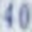

LABELS:


array([ 4,  0, 10, 10, 10])

MAXIMUM WIDTH IMAGE
FILE NAME: 1723.png
ORIGINAL IMAGE:


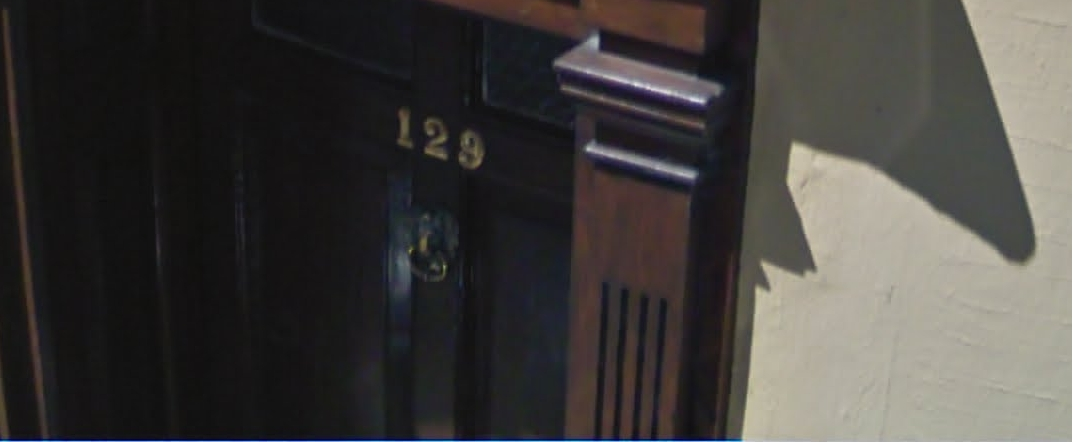

NUMBER OF DIGITS: 3
FOR DIGIT 1
  LEFT: 390
  WIDTH: 34
  TOP: 106
  HEIGHT: 67
  LABEL: 1
FOR DIGIT 2
  LEFT: 424
  WIDTH: 30
  TOP: 106
  HEIGHT: 67
  LABEL: 2
FOR DIGIT 3
  LEFT: 450
  WIDTH: 43
  TOP: 106
  HEIGHT: 67
  LABEL: 9
PROCESSED IMAGE:


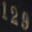

LABELS:


array([ 1,  2,  9, 10, 10])

MINIMUM HEIGHT IMAGE
FILE NAME: 146.png
ORIGINAL IMAGE:


NUMBER OF DIGITS: 2
FOR DIGIT 1
  LEFT: 16
  WIDTH: 9
  TOP: 1
  HEIGHT: 12
  LABEL: 2
FOR DIGIT 2
  LEFT: 23
  WIDTH: 8
  TOP: 1
  HEIGHT: 12
  LABEL: 3
PROCESSED IMAGE:


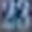

LABELS:


array([ 2,  3, 10, 10, 10])

MAXIMUM HEIGHT IMAGE
FILE NAME: 15.png
ORIGINAL IMAGE:


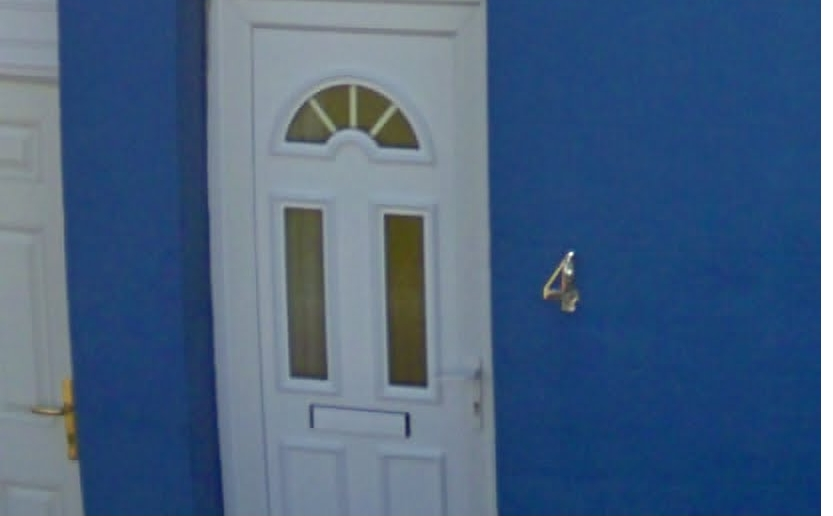

NUMBER OF DIGITS: 1
FOR DIGIT 1
  LEFT: 524
  WIDTH: 71
  TOP: 235
  HEIGHT: 91
  LABEL: 4
PROCESSED IMAGE:


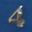

LABELS:


array([ 4, 10, 10, 10, 10])

MINIMUM AREA IMAGE
FILE NAME: 5353.png
ORIGINAL IMAGE:


NUMBER OF DIGITS: 2
FOR DIGIT 1
  LEFT: 6
  WIDTH: 8
  TOP: 1
  HEIGHT: 12
  LABEL: 1
FOR DIGIT 2
  LEFT: 14
  WIDTH: 9
  TOP: 1
  HEIGHT: 12
  LABEL: 10
PROCESSED IMAGE:


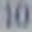

LABELS:


array([ 1,  0, 10, 10, 10])

MAXIMUM AREA IMAGE
FILE NAME: 1723.png
ORIGINAL IMAGE:


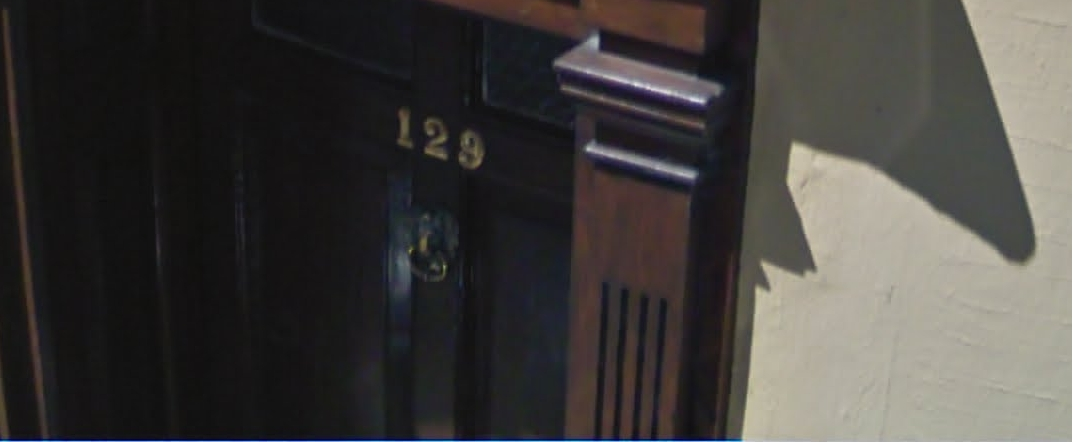

NUMBER OF DIGITS: 3
FOR DIGIT 1
  LEFT: 390
  WIDTH: 34
  TOP: 106
  HEIGHT: 67
  LABEL: 1
FOR DIGIT 2
  LEFT: 424
  WIDTH: 30
  TOP: 106
  HEIGHT: 67
  LABEL: 2
FOR DIGIT 3
  LEFT: 450
  WIDTH: 43
  TOP: 106
  HEIGHT: 67
  LABEL: 9
PROCESSED IMAGE:


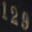

LABELS:


array([ 1,  2,  9, 10, 10])

array([ 3,  4, 10, 10, 10])

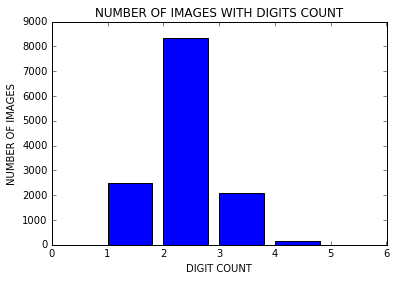

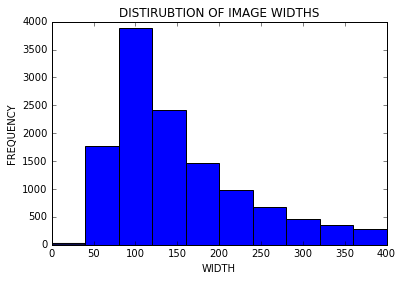

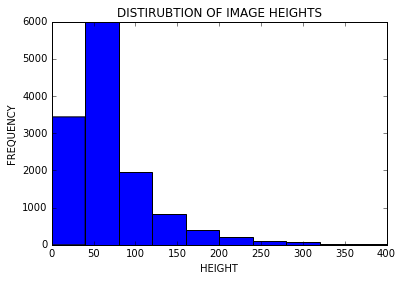

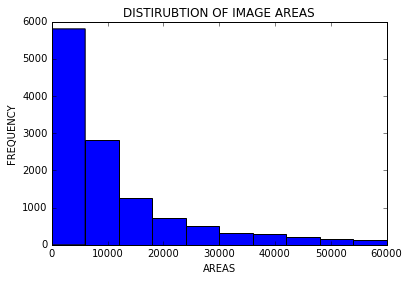

In [6]:
# test dataset
testDigitObject = DigitImages(test_folder)
(test_data, test_labels) = testDigitObject.getDataLabels() 
testDigitObject.explore()
display(test_labels[10])

## Dump dataset to read for training

In [7]:
# write multiple SVHN file
def writeDataSets(base_file_name, data, labels):
    ''' write pre-processed data in pickle files to read while creating model '''
    batch_size = 5000
    num_batches = len(data)/batch_size
    if len(data)%batch_size != 0:
        num_batches = num_batches + 1
    for i in range(num_batches):
        start_range = batch_size*i
        end_range = (batch_size)*(i+1)
        if end_range > len(data):
            end_range = len(data)
        file_name = base_file_name + str(i) + '.pickle'
    
        try:
            f = open(file_name, 'wb')
            save = {
                "data":data[start_range:end_range],
                "labels":labels[start_range:end_range]
            }
            pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
            f.close()
        except Exception as e:
            print('Unable to create pickle file :', e)
            raise
        statinfo = os.stat(file_name)
        print('Compressed pickle file size:', statinfo.st_size)
        print file_name
        print start_range
        print end_range

In [8]:
# dump training data
writeDataSets('SVHN_train', train_data, train_labels)

('Compressed pickle file size:', 20580237L)
SVHN_train0.pickle
0
5000
('Compressed pickle file size:', 20580237L)
SVHN_train1.pickle
5000
10000
('Compressed pickle file size:', 20580237L)
SVHN_train2.pickle
10000
15000
('Compressed pickle file size:', 20580237L)
SVHN_train3.pickle
15000
20000
('Compressed pickle file size:', 20580237L)
SVHN_train4.pickle
20000
25000
('Compressed pickle file size:', 20580237L)
SVHN_train5.pickle
25000
30000
('Compressed pickle file size:', 14002869L)
SVHN_train6.pickle
30000
33402


In [9]:
# dump testing data
writeDataSets('SVHN_test', test_data, test_labels)

('Compressed pickle file size:', 20580237L)
SVHN_test0.pickle
0
5000
('Compressed pickle file size:', 20580237L)
SVHN_test1.pickle
5000
10000
('Compressed pickle file size:', 12628125L)
SVHN_test2.pickle
10000
13068


In [10]:
def readData(pickleFiles):
    ''' read pickle data'''
    data = None
    labels = None
    for pf in pickleFiles:
        with open(pf, 'rb') as f:
            save = pickle.load(f)
            if data == None:
                data = save['data']
                labels = save['labels']
            else:
                data = np.concatenate((data, save['data']))
                labels = np.concatenate((labels, save['labels']))
            print len(data)
            print len(labels)
        del save
    return (data, labels)

In [11]:
train_pickle_files = ['SVHN_train0.pickle', 'SVHN_train1.pickle', 'SVHN_train2.pickle', 'SVHN_train3.pickle', \
                      'SVHN_train4.pickle', 'SVHN_train5.pickle', 'SVHN_train6.pickle']
test_pickle_files = ['SVHN_test0.pickle', 'SVHN_test1.pickle', 'SVHN_test2.pickle']
(new_train_data, new_train_labels) = readData(train_pickle_files)
(new_test_data, new_test_labels) = readData(test_pickle_files)

5000
5000
10000
10000
15000
15000
20000
20000
25000
25000
30000
30000
33402
33402
5000
5000
10000
10000
13068
13068


C:\Users\jmd\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [12]:
# sanity check for dumped data
display(np.array_equal(train_data, new_train_data))
display(np.array_equal(test_data, new_test_data))
display(np.array_equal(train_labels, new_train_labels))
display(np.array_equal(test_labels, new_test_labels))

True

True

True

True